# Running QFT on real IBM QC

In this Notebook I tey to run my QFT code on real IBM QC.

In [1]:
import numpy as np
import sys
import math
import time
sys.path
sys.path.insert(0, 'C:/Users/Oleg/Google Диск/QC/Codes/QC-qiskit-codes/Shor')
sys.path.insert(0, 'C:/Users/Oleg/Google Диск/QC/Codes/QC-qiskit-codes/Library')

import qiskit
from qiskit import QuantumRegister as Q_R
from qiskit import ClassicalRegister as C_R
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

import quantum_routines as qr
import aux_func as af

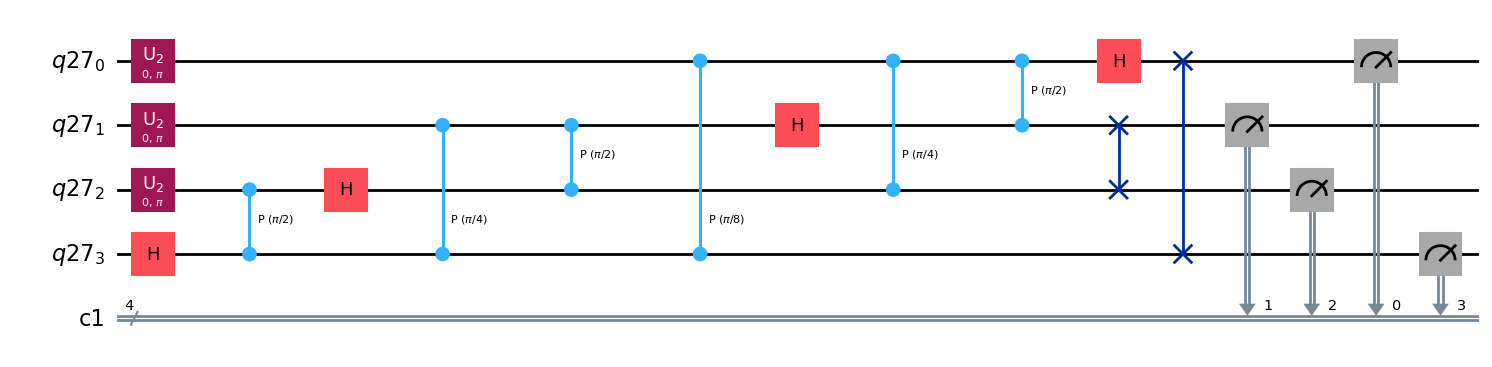

In [10]:
bit_size = 4

inp_num = [0, 0, 0, 0]

q_reg = Q_R(bit_size)
cl_reg = C_R(bit_size)
QFT = qiskit.QuantumCircuit(q_reg,cl_reg)

QFT = qr.qubit_binary_prepare(q_reg, inp_num, QFT)
QFT.h(0)
QFT.h(1)
QFT.h(2)


instr = qr.QFTn_instr(bit_size)
QFT.append(instr, q_reg)
QFT = qr.qubits_meas(q_reg, cl_reg, QFT)

QFT.decompose().draw('mpl')

In [12]:
QFT.decompose().depth()

9

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)
backend

<IBMBackend('ibm_brisbane')>

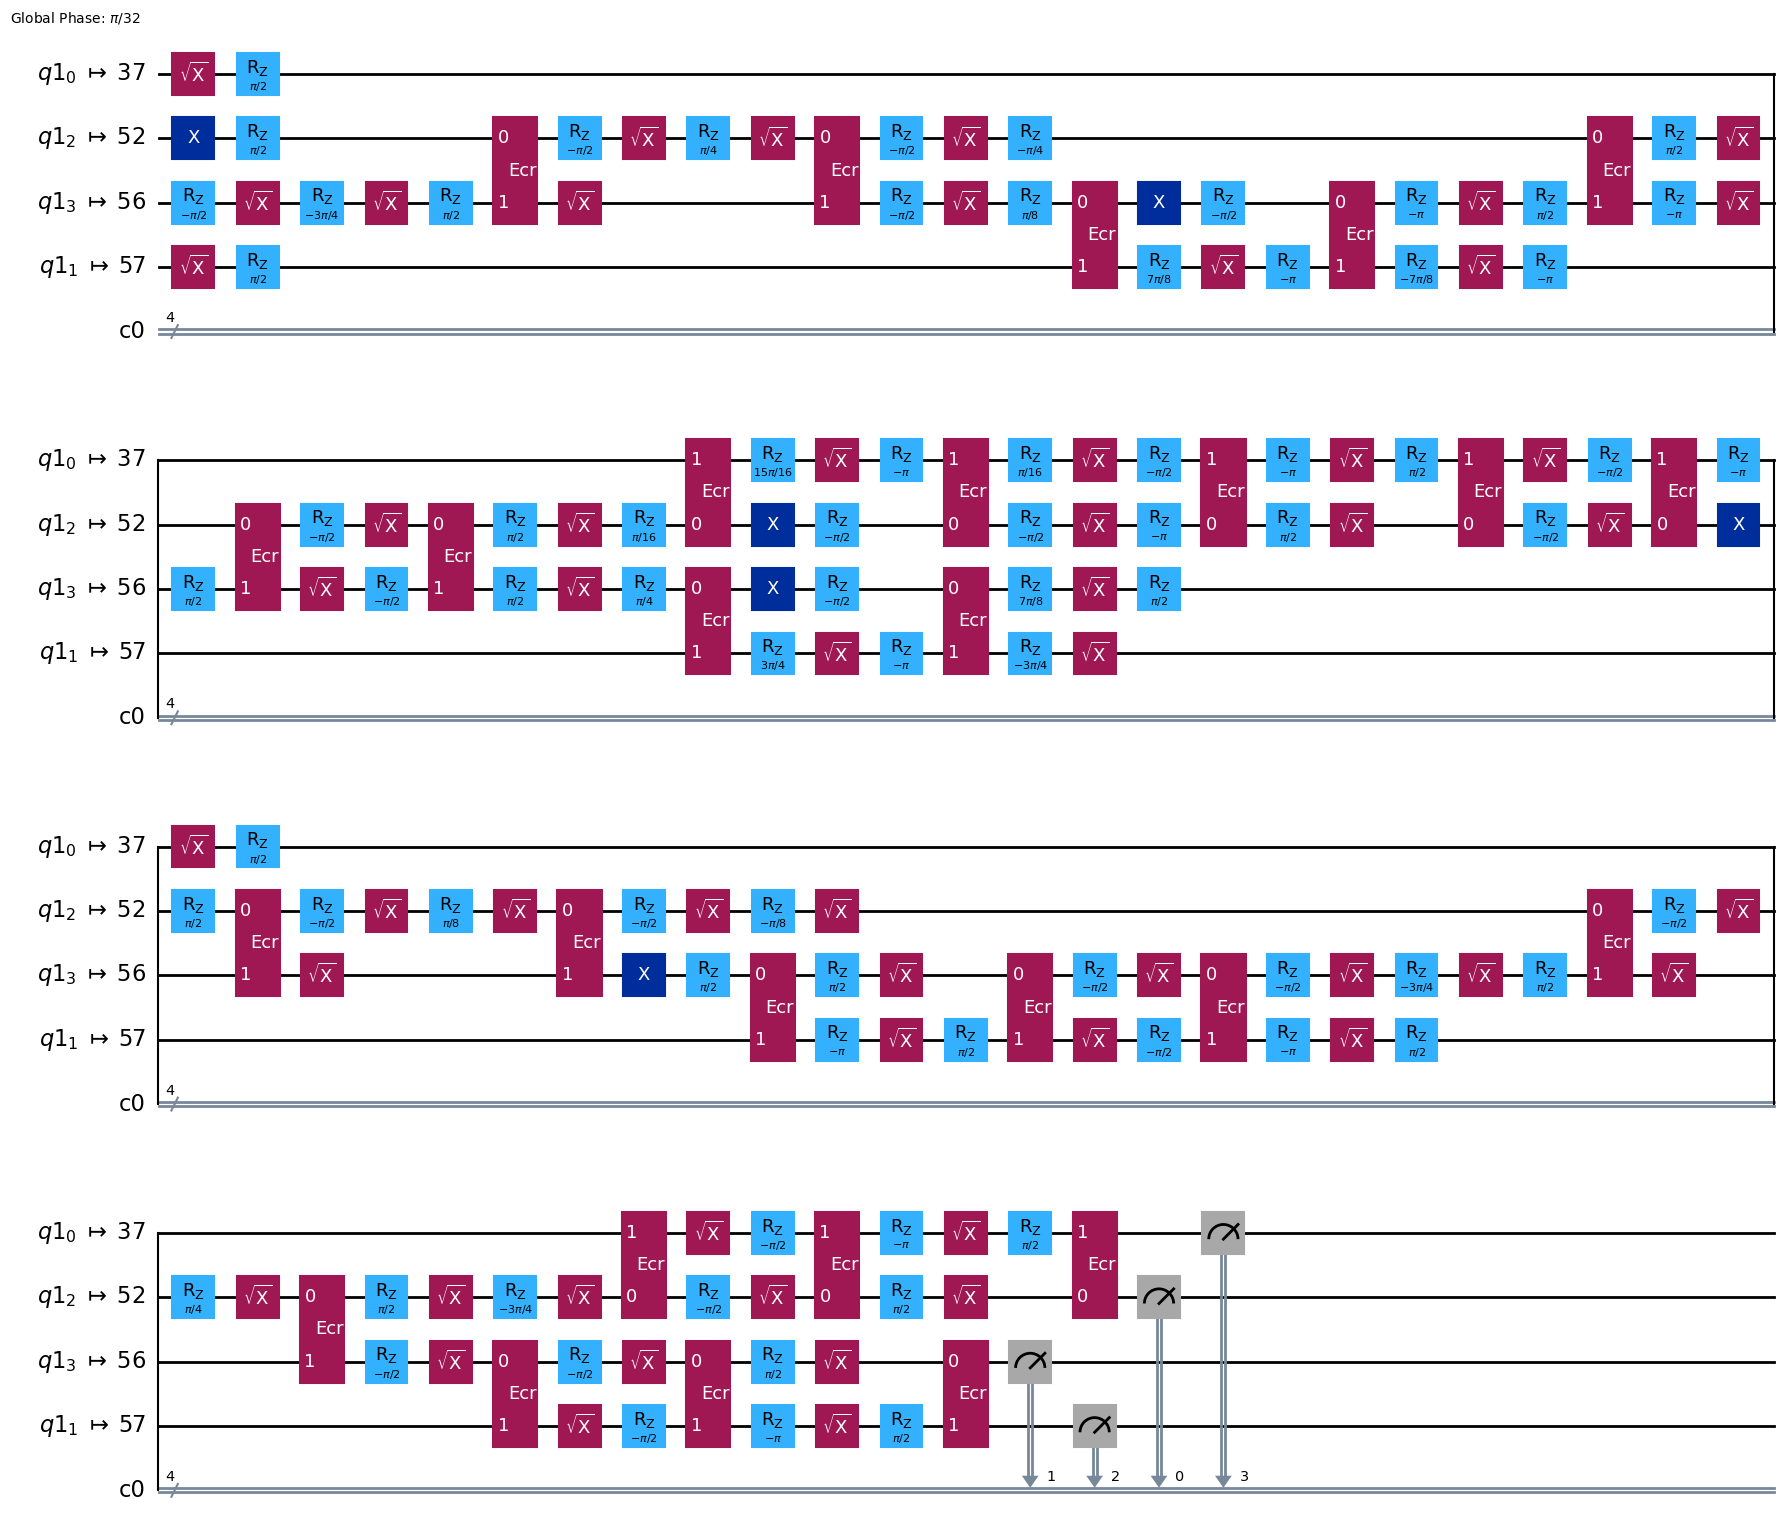

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(QFT)
isa_circuit.draw('mpl', idle_wires=False)


In [13]:
isa_circuit.depth()

91

In [16]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit])
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")



>>> Job ID: cwh9m7r31we00087yf40
>>> Job Status: QUEUED


In [17]:
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cwh9m7r31we00087yf40
>>> Job Status: QUEUED


In [18]:
result = job.result()

In [36]:
pub_result = result[0]
pub_result
counts = result[0].data.c0.get_counts()
counts
#print(f"Counts for the meas output register: {pub_result.data.meas.get_counts()}")

{'1101': 92,
 '0000': 1464,
 '1110': 636,
 '0100': 180,
 '1111': 667,
 '0110': 113,
 '1100': 225,
 '0010': 103,
 '1001': 57,
 '1010': 47,
 '0111': 100,
 '0001': 196,
 '1000': 47,
 '0101': 49,
 '1011': 52,
 '0011': 68}

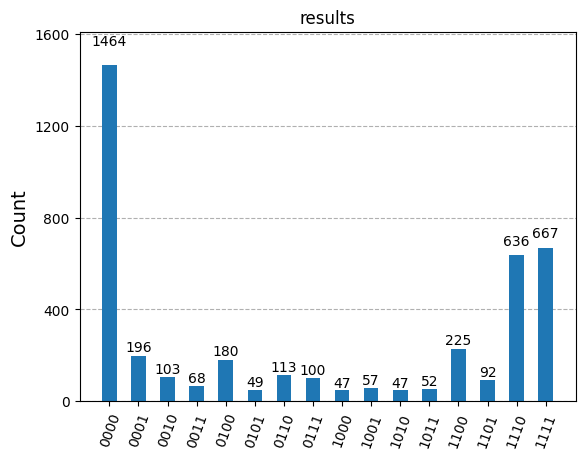

In [37]:
from qiskit.visualization import plot_histogram

plot_histogram(counts, title = 'results')

## Using different backends

In [3]:
#from qiskit_ibm_runtime import QiskitRuntimeService
#QiskitRuntimeService.save_account(channel="ibm_quantum", token="2c4fd7dc9f87f9120242bc0d8465e1afc8e7eaabe6e32998dc6043815eb64b5fa0e6f52c4a59a59a1b3545e38277b4631895d39b7075dae9336fa771acacc2fd")

### Aer simulator

['time elapsed: 2.009800434112549 sec']


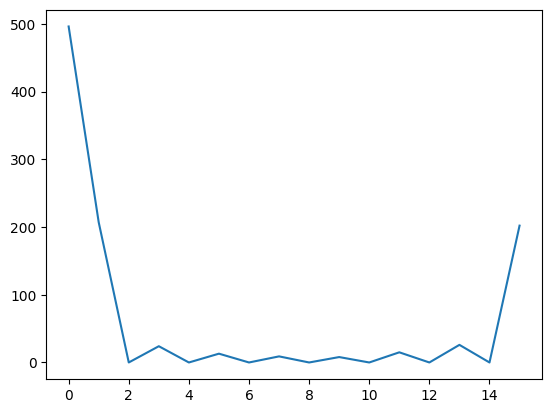

In [4]:
start = time.time()
shot_num = 1000
simulator = AerSimulator()
QFT = transpile(QFT, simulator)
result = simulator.run(QFT,shots = shot_num).result()
counts = result.get_counts(QFT)
end = time.time()
print(['time elapsed: ' + str(end - start) + ' sec'])
af.plot_counts(counts, bit_size)

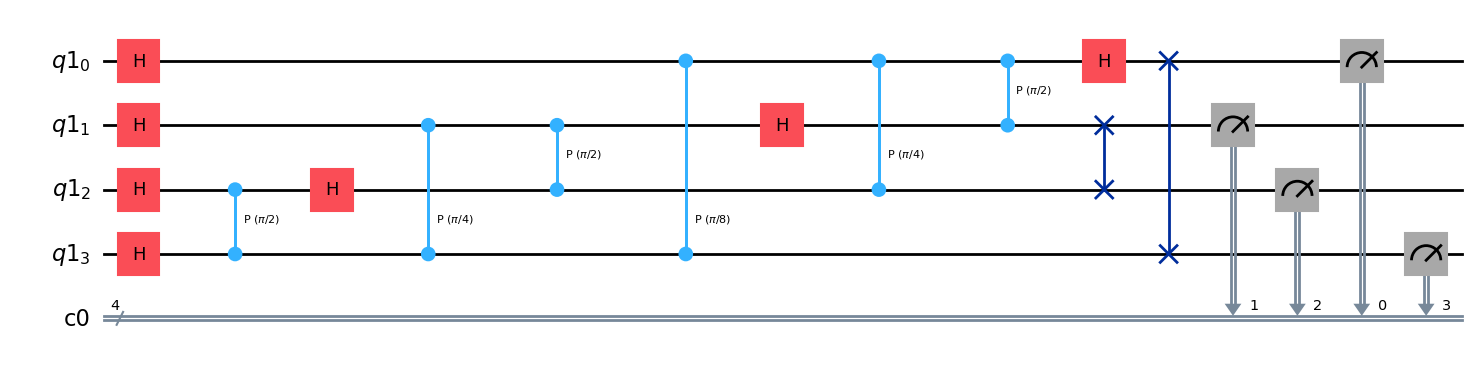

In [5]:
QFT.draw('mpl')

## Using quantum_info class to simulate the circuit
This method works when the circuit does not contain any measurements in it.

This class allows to get the final wave function using Statevector method.

One can then get ideal probabilirties to get any of these states. This can be done using probabilities method applied directly to the wave-function.

Finally, one can run counting emulating multiple tries to run the circuit. This is done by applying sample_counts method to the wavr function.




In [6]:
from qiskit import quantum_info

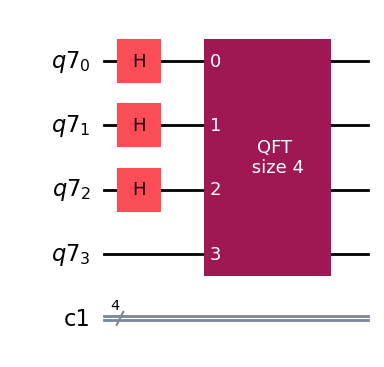

In [7]:
bit_size = 4

inp_num = [0, 0, 0, 0]

q_reg = Q_R(bit_size)
cl_reg = C_R(bit_size)
QFT = qiskit.QuantumCircuit(q_reg,cl_reg)

QFT = qr.qubit_binary_prepare(q_reg, inp_num, QFT)
QFT.h(0)
QFT.h(1)
QFT.h(2)


instr = qr.QFTn_instr(bit_size)
QFT.append(instr, q_reg)
#QFT = qr.qubits_meas(q_reg, cl_reg, QFT)

QFT.draw('mpl')

In [8]:
psi = quantum_info.Statevector(QFT)
print(psi)

Statevector([ 7.07106781e-01+0.00000000e+00j,
              8.83883476e-02+4.44358231e-01j,
              1.68365798e-18+4.06470994e-18j,
              8.83883476e-02+1.32282510e-01j,
              8.34944624e-18+8.34944624e-18j,
              8.83883476e-02+5.90592057e-02j,
              1.68365798e-18+6.97393972e-19j,
              8.83883476e-02+1.75815355e-02j,
             -9.52420783e-18+0.00000000e+00j,
              8.83883476e-02-1.75815355e-02j,
              1.68365798e-18-6.97393972e-19j,
              8.83883476e-02-5.90592057e-02j,
              8.34944624e-18-8.34944624e-18j,
              8.83883476e-02-1.32282510e-01j,
              1.68365798e-18-4.06470994e-18j,
              8.83883476e-02-4.44358231e-01j],
            dims=(2, 2, 2, 2))


In [9]:
probablitites = psi.probabilities()
print(probablitites)
sum(probablitites)

[5.00000000e-01 2.05266737e-01 1.93565711e-35 2.53111626e-02
 1.39426505e-34 1.13004898e-02 3.32106256e-36 8.12161039e-03
 9.07105347e-35 8.12161039e-03 3.32106256e-36 1.13004898e-02
 1.39426505e-34 2.53111626e-02 1.93565711e-35 2.05266737e-01]


0.999999999999999

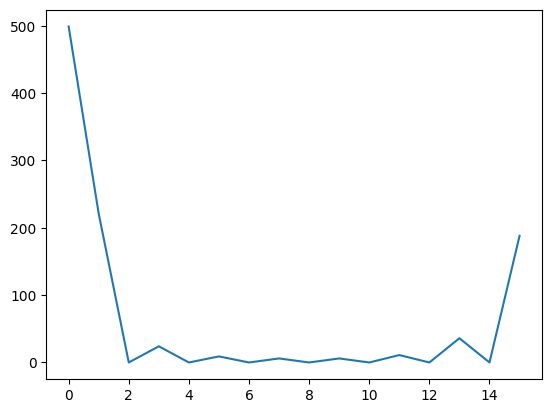

In [10]:
counts = psi.sample_counts(shots = 1000)
af.plot_counts(counts, bit_size)

## BasicSimulator
This is the most simple simulator in Qiskit
# Notes on this simulator
1. It cannot run a circuit with more than 24 qubits!
2. You cannot get the wavefunction of the final state, only classical register values.
3. there is no noise in this kind of simulator.

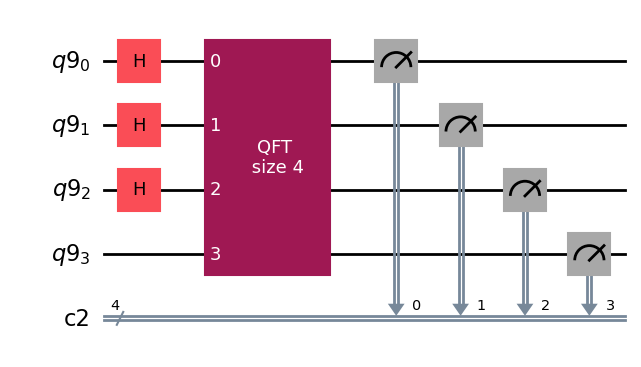

In [11]:
bit_size = 4

inp_num = [0, 0, 0, 0]

q_reg = Q_R(bit_size)
cl_reg = C_R(bit_size)
QFT = qiskit.QuantumCircuit(q_reg,cl_reg)

QFT = qr.qubit_binary_prepare(q_reg, inp_num, QFT)
QFT.h(0)
QFT.h(1)
QFT.h(2)


instr = qr.QFTn_instr(bit_size)
QFT.append(instr, q_reg)
QFT = qr.qubits_meas(q_reg, cl_reg, QFT)


QFT.draw('mpl')

In [12]:
from qiskit.providers.basic_provider import BasicSimulator

In [13]:
simulator_object = BasicSimulator()
QFT = qiskit.transpile(QFT, simulator_object)
#QFT.draw('mpl')
job = simulator_object.run(QFT, shots = 1024)
results = job.result()
counts = results.get_counts()
counts

{'0000': 501,
 '0001': 202,
 '0101': 12,
 '1111': 214,
 '1101': 30,
 '1011': 14,
 '0111': 14,
 '1001': 8,
 '0011': 29}

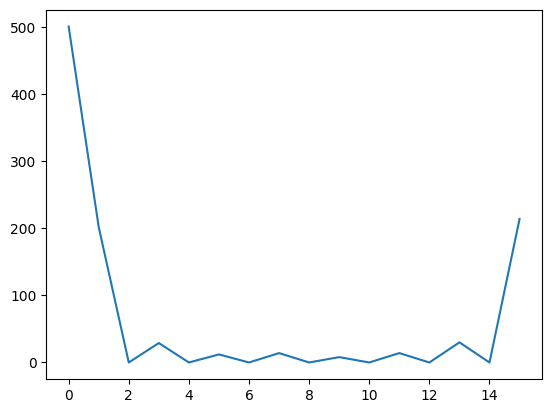

In [14]:
af.plot_counts(counts, bit_size)

## QASM simulator

In [15]:
#from qiskit import BasicAer
simulator = AerSimulator()
backend = simulator.get_backend('qasm_simulator')
from qiskit.execute_function import execute
job = execute(QFT, backend)
result = job.result()
counts = result.get_counts()

AttributeError: 'AerSimulator' object has no attribute 'get_backend'

## Extended stabilizer

In [20]:
start = time.time()
extended_stabilizer_simulator = AerSimulator(method='extended_stabilizer')
t_QFT = transpile(QFT, extended_stabilizer_simulator)
extended_stabilizer_result = extended_stabilizer_simulator.run(t_QFT, shots=100).result()
counts = extended_stabilizer_result.get_counts()
end = time.time()
print(['time elapsed: ' + str(end - start) + ' sec'])

['time elapsed: 74.7653911113739 sec']


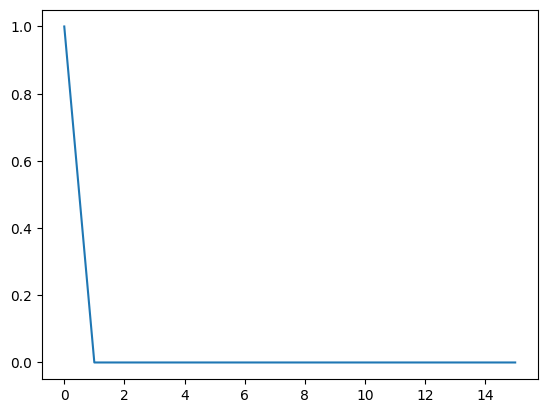

In [17]:
af.plot_counts(counts, bit_size)